# Mnist手写数字识别神经网络

### 导入数据集

dict_keys(['image', 'label'])
<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x1EA81524470>
5


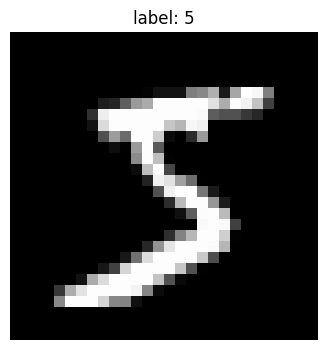

In [61]:
from random import sample
from datasets import load_from_disk
import matplotlib.pyplot as plt

dataset  = load_from_disk("D:/AILearn/Deep learning network/node/data/mnist")

train_data = dataset["train"]
test_data = dataset["test"]
sample = train_data[0]
print(sample.keys())
print(sample["image"])
print(sample["label"])

plt.figure(figsize=(4, 4))
plt.imshow(sample["image"],cmap="gray")  # 使用灰度色彩映射
plt.title(f'label: {sample["label"]}')
plt.axis('off')  # 不显示坐标轴
plt.show()


### 确定网络结构以及形状
隐藏层参数 W(784,64) b(1,64)
输出层参数 W(64,10) b(1,10)
softmax -> 概率值  
### 流程
1. 获取数据
2. 前向传播：网格结构定义
3. 损失计算
4. 反向传播 梯度下降优化
功能性模块：
· 准确率计算
· Tensorboard可视化
·  训练模型保存 加载 预测

In [62]:
import torch
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def transform_example(example):
    example['image'] = torchvision.transforms.ToTensor()(example['image'])
    example['image'] = torchvision.transforms.Normalize(mean=[0.5], std = [0.5])(example['image'])
    example['label'] = torch.tensor(example['label'], dtype=torch.int64)
    return example

train = train_data.map(transform_example)
test = test_data.map(transform_example)

train.set_format(type='torch')
test.set_format(type='torch')

train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

In [63]:
class DeepNN(torch.nn.Module):
    def __init__(self,input_size = 784,hidden_size = [128,64],output_size = 10):
        super(DeepNN,self).__init__()
        self.fc1 = torch.nn.Linear(input_size,hidden_size[0])
        self.fc2 = torch.nn.Linear(hidden_size[0],hidden_size[1])
        self.fc3 = torch.nn.Linear(hidden_size[1],output_size)
        self.dropout = torch.nn.Dropout(0.2)#随机丢弃20%的神经元，防止过拟合
    
    def forward(self,x):
        x = x.view(-1,784) #将输入数据展平为一维向量
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [64]:
from torch import nn
import tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/mnist_experiment")

model = DeepNN().to(device)
criterion = nn.CrossEntropyLoss() #内含 softmax 交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters(),lr=0.01) #随机梯度下降优化器
epoches = 10#训练轮数




def train(model,train_loader,criterion,optimizer,epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data["image"].to(device), data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() #封装了梯度计算
            optimizer.step() #根据梯度更新参数

            running_loss += loss.item()
            if i % 100 == 99:    # 每100个batch打印一次
                #print(model.fc1.weight.grad)  # 查看第一个全连接层权重的梯度
                #print(model.fc1.bias.grad)    # 查看第一个全连接层偏置的梯度
                avg_loss = running_loss / 100
                writer.add_scalar("train_loss", avg_loss, epoch * len(train_loader) + i)

                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, avg_loss))  
                running_loss = 0.0
    writer.close()
    print('Finished Training')
    return model

dict_keys(['image', 'label'])
<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x1EA818DDAC0>
5


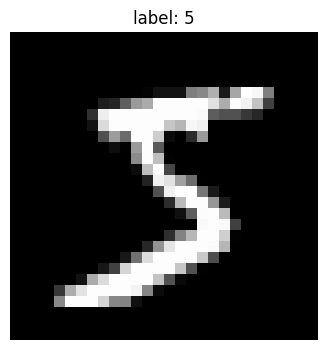

In [65]:
from random import sample
from datasets import load_from_disk
import matplotlib.pyplot as plt

dataset  = load_from_disk("D:/AILearn/Deep learning network/node/data/mnist")

train_data = dataset["train"]
test_data = dataset["test"]
sample = train_data[0]
print(sample.keys())
print(sample["image"])
print(sample["label"])

plt.figure(figsize=(4, 4))
plt.imshow(sample["image"],cmap="gray")  # 使用灰度色彩映射
plt.title(f'label: {sample["label"]}')
plt.axis('off')  # 不显示坐标轴
plt.show()


In [66]:
def test(model,test_loader):
    model.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data['image'].to(device), data['label'].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    writer.add_scalar('Accuracy/test', accuracy, epoch)
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


In [67]:
train_model = train(model,train_loader,criterion,optimizer,epoches)

save_path = "D:/AILearn/Deep learning network/saved_model/mnist_model.pth"

test(model,test_loader)
torch.save(model.state_dict(),save_path)

[1,   100] loss: 1.571
[1,   200] loss: 1.030
[1,   300] loss: 0.988
[1,   400] loss: 0.899
[1,   500] loss: 0.934
[1,   600] loss: 0.876
[1,   700] loss: 0.844
[1,   800] loss: 0.871
[1,   900] loss: 0.854
[1,  1000] loss: 0.885
[1,  1100] loss: 0.890
[1,  1200] loss: 0.838
[1,  1300] loss: 0.855
[1,  1400] loss: 0.822
[1,  1500] loss: 0.820
[1,  1600] loss: 0.920
[1,  1700] loss: 0.839
[1,  1800] loss: 0.862
[2,   100] loss: 0.881
[2,   200] loss: 0.882
[2,   300] loss: 0.930
[2,   400] loss: 0.863
[2,   500] loss: 0.815
[2,   600] loss: 0.812
[2,   700] loss: 0.777
[2,   800] loss: 0.837
[2,   900] loss: 0.901
[2,  1000] loss: 0.840
[2,  1100] loss: 0.839
[2,  1200] loss: 0.868
[2,  1300] loss: 0.833
[2,  1400] loss: 0.796
[2,  1500] loss: 0.809
[2,  1600] loss: 0.798
[2,  1700] loss: 0.852
[2,  1800] loss: 0.811
[3,   100] loss: 0.794
[3,   200] loss: 0.803
[3,   300] loss: 0.786
[3,   400] loss: 0.851
[3,   500] loss: 0.803
[3,   600] loss: 0.873
[3,   700] loss: 0.768
[3,   800] 

KeyboardInterrupt: 